In [56]:
import os
from typing import TypedDict, Annotated, Literal, List, Any
from dotenv import load_dotenv
from langchain.agents import create_agent
from langchain.agents.middleware import after_model
# from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain.tools import tool, ToolRuntime
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt
from langchain_core.prompts import ChatPromptTemplate
# from langgraph.runtime import Runtime
from langgraph.graph import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.stores import InMemoryStore
# from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import DuckDuckGoSearchRun
from pydantic import BaseModel, Field

In [57]:
class RLAgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    user_input: str
    steps: str
    reasoning: str
    changes: list[str]
    first_response: str
    current_response: str
    final_response: str
    jump_to: str
    content: list[Any]
    insights: str
    first_run: bool
    counter: int
    max_loop: int

In [58]:
store = InMemoryStore()
user_id = '1'
namespace = (user_id, 'insights')

In [59]:
model = ChatGoogleGenerativeAI(
    model='gemini-2.5-flash',
    temperature=0.2,
    api_key=os.getenv('GOOGLE_API_KEY')
)

In [60]:
search = DuckDuckGoSearchRun()
# search.invoke("Obama's first name?")

In [61]:
tools = [search]

In [62]:
search_agent = create_agent(model=model, tools=tools, state_schema=RLAgentState)

In [63]:
model_with_tools = model.bind_tools(tools)

In [64]:
class Reasoning(BaseModel):
    steps: str = Field(description='All the planned steps in order', min_length=1)
    reasoning: str = Field(description='Reasoning and thought process', min_length=1)

class Research(BaseModel):
    target_age_group: Literal['18 and below','18-45','45 and above']
    target_gender: Literal['Male','Female', 'Non-Binary', 'Everyone']
    target_persona: str = Field(description='Persona of people who might be interested in this', min_length=1)

In [65]:
reasoning_prompt = ChatPromptTemplate.from_template(
    """
    You are given a user input {input}. Your job is to plan your steps and mention your reasoning/ thought process behind your planning. You have these tools: {tools},
    In your reasoning mention your indepth thought process and explanations as to why you think this is the correct approach.
    """
)
reasoning_chain = reasoning_prompt | model.with_structured_output(Reasoning)

reasoning_with_insights_prompt = ChatPromptTemplate.from_template(
    """
    You are given a user input {input} and insights from previous runs {insights}. Your job is to plan your steps for tackling the query and mention your reasoning or thought process behind your planning for each step. You have these tools: {tools}.
    In your reasoning mention your indepth thought process and explanations as to why you think this is the correct approach.
    """
)
reasoning_with_insights_chain = reasoning_with_insights_prompt | model.with_structured_output(Reasoning)

In [ ]:
@tool
def search_browser(query : str | None, runtime: ToolRuntime[None | RLAgentState]) -> Command:
    """
    This tool calls another agent who search the web to find results
    :param query: str
    :return: Command
    """
    print('\nEntering search browser tool.....')
    messages = runtime.state['messages']
    # tool_call_id = state['messages'][-1].tool_calls[-1]['id']

    res = search_agent.invoke({
        'messages': [SystemMessage(content='You are an agent who can use search tools to fnd the most relevant texts based on the user queries from the web')] + messages,
    })

    # res = search_agent.invoke({
    #     'messages': SystemMessage(content='You are an agent who can use search tools to fnd the most relevant texts based on the user queries from the web') + HumanMessage(content=query),
    # })

    return Command(update=
        {
            'messages': [ToolMessage(content=res['messages'][-1].content, tool_call_id=runtime.tool_call_id)]
        }
    )
@tool
def create_research(runtime: ToolRuntime[None | RLAgentState]) -> Command:
    """
    This tool calls another agent who creates a research based on all the gathered information from tools
    :return: Command
    """
    print('\nEntering Research tool.....')
    messages = runtime.state['messages']

    system_message = SystemMessage(content='You are an agent that conducts research based on the provided details and responds in a structured way')

    res = model.with_structured_output(Research).invoke([system_message]+messages)
    out_message = f"""
    The Research conducted is as follows:
    The Target Age group is {res.target_age_group},
    The Target Gender is {res.target_gender},
    The Target Persona who is interested is {res.target_persona},
    """

    if runtime.state['first_run']:

        return Command(update=
            {
                'messages' : [ToolMessage(content=out_message, tool_call_id=runtime.tool_call_id)],
                'first_run': False,
                'first_response': out_message,
                'current_response': out_message,
                'content': [res.target_age_group,res.target_gender,res.target_persona]
            }
        )

    else:
        return Command(update=
            {
                'messages' : [ToolMessage(content=out_message, tool_call_id=runtime.tool_call_id)],
                'current_response': res,
                'content': [res.target_age_group,res.target_gender,res.target_persona]
            }
        )


In [67]:
# def convert_to_google_messages(messages):
#     new_messages = []
#     for message in messages:
#         if isinstance(message, SystemMessage):
#             new_message = {
#                 'role': 'system',
#                 'content': message.content
#             }
#         elif isinstance(message, HumanMessage):
#             new_message

#         new_messages.append(new_message)

In [68]:
tool_agents = [search_browser, create_research]

def planning_reasoning_step(state: RLAgentState):
    print('\nEntering Planning Reasoning Node.......')
    if state['first_run']:

        res = reasoning_chain.invoke(
            {
                'input' : state['user_input'],
                'tools' : tools+tool_agents,
            }
        )

        return {
            'messages' : AIMessage(content='The Plan is as follows : ' + res.steps + '\n\n' +
                                           'The reasoning for them is as follows : ' + res.reasoning),
            'reasoning' : res.reasoning,
            'steps': res.steps,
        }

    else:

        res = reasoning_with_insights_chain.invoke(
            {
                'input' : state['user_input'],
                'insights': state['insights'],
                'tools' : tools+tool_agents,
            }
        )

        return {
            'messages' : AIMessage(),
            'reasoning' : res.reasoning,
            'steps' : res.steps,
        }


def router(state: RLAgentState):
    print('\nEntering Router .....')
    messages = state['messages']
    # parsed_messages = convert_to_google_messages(messages)

    res = model.bind_tools(tool_agents).invoke(messages)
    try:
        print(f'\nTool called: {res.tool_calls[0]['name']}')
    except:
        print('\nNo tool called')
    return {
        'messages' : res
    }

def which_agent(state: RLAgentState)->Literal['search_agent',END]:

    last_message = state['messages'][-1]
    if len(last_message.tool_calls)>0:
        tool = last_message.tool_calls[0]['name']
        if tool == 'search_browser':
            return 'search_agent'
        elif tool == 'create_research':
            return 'research_agent'
        else:
            return END

    else:
        return END

def hitl(state: RLAgentState):
    print('\nEntering HITL.......')
    output = [state['reasoning'], state['current_response'], state['content']]
    changes = interrupt(
        output
    )

    if changes == 'Approved':
        return {
            'messages': AIMessage(content='No changes needed. Proceed to Finalise Research'),
            'final_response': state['current_response'],
            'jump_to': 'END'
        }

    else:
        return {
            'messages': AIMessage(content='Changes added. Refer them to redo research'),
            'changes': state['changes'].append(changes),
            'jump_to': 'router'
        }

def is_approved(state: RLAgentState)->Literal[END,'router']:

    if state['jump_to'] == 'END':
        return END
    else:
        return 'router'

search_browser_node = ToolNode(name='search_agent', tools=[search_browser])
create_research_node = ToolNode(name='research_agent', tools=[create_research])
# tool_agents_node = ToolNode(name='tool_agents', tools=tool_agents)

In [69]:
checkpointer = InMemorySaver()
config = {
    'configurable' : {
        'thread_id': '1'
    }
}

In [70]:
def test_is_tool_call(state: RLAgentState)->Literal['tool_agents', END]:

    last_message = state['messages'][-1]

    if len(last_message.tool_calls)>0:
        return 'tool_agents'
    else:
        return END

In [71]:
graph = StateGraph(RLAgentState)

graph.add_node('planning_reasoning', planning_reasoning_step)
graph.add_node('router', router)
# graph.add_node('tool_agents', tool_agents_node)
graph.add_node('search_browser', search_browser_node)
graph.add_node('create_research', create_research_node)
# graph.add_node('hitl', hitl)
graph.add_edge(START, 'planning_reasoning')
graph.add_edge('planning_reasoning', 'router')
# graph.add_conditional_edges('router', test_is_tool_call)
graph.add_conditional_edges('router', which_agent, {
    'search_agent': 'search_browser',
    'research_agent':'create_research',
    END : END
})
graph.add_edge('search_browser','router')
graph.add_edge('create_research', 'router')
# graph.add_edge('create_research', 'hitl')
# graph.add_edge('tool_agents', 'router')
# graph.add_edge('tool_agents', 'hitl')
# graph.add_conditional_edges('hitl', is_approved, {
#     END: END,
#     'router': 'router'
# })

agent = graph.compile(checkpointer=checkpointer)

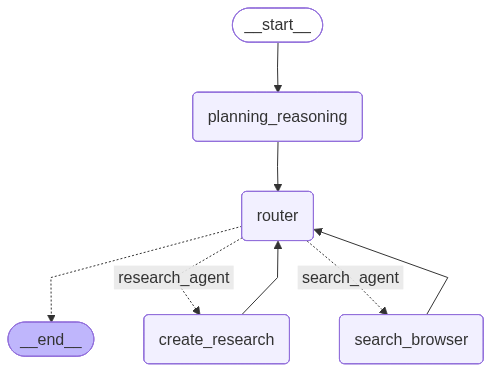

In [72]:
from IPython.display import Image

Image(agent.get_graph().draw_mermaid_png())

In [73]:
input = 'Hotwheels Porsche 911'

In [74]:
res = agent.invoke(
    {
        'messages': HumanMessage(content=input),
        'user_input': input,
        'insights': '',
        'first_run': True,
        'counter': 0,
        'max_loop': 2,
    },
    config=config
)


Entering Planning Reasoning Node.......

Entering Router .....

Tool called: search_browser

Entering search browser tool.....

Entering Router .....

Tool called: create_research

Entering Research tool.....

Entering Router .....

No tool called


In [79]:
for msg in res['messages']:
    msg.pretty_print()

================================ Human Message =================================

Hotwheels Porsche 911
================================== Ai Message ==================================

The Plan is as follows : 1. Use the 'search_browser' tool with the query 'Hotwheels Porsche 911' to gather comprehensive information about various models, series, release dates, collector information, and any other relevant details. 2. Once the information is gathered, use the 'create_research' tool to synthesize all the collected data into a structured research document.

The reasoning for them is as follows : The user's input 'Hotwheels Porsche 911' indicates a need for information about this specific topic. My plan is designed to efficiently gather and present this information. 

**Step 1: Information Gathering (search_browser)**
I will start by using the 'search_browser' tool. I chose 'search_browser' over 'DuckDuckGoSearchRun' because 'search_browser' is described as an agent that 'search the web t

In [76]:
res['content']

['18-45',
 'Everyone',
 'Collectors and enthusiasts of diecast cars, particularly Hot Wheels and Porsche models.']

In [ ]:
res2 = agent.invoke(Command(resume='The research target persona should be only Men who are interested in Hair Care and not Men who like to color their hair'), config=config)

In [78]:
for msg in res2['messages']:
    msg.pretty_print()

================================ Human Message =================================

Hotwheels Porsche 911
================================== Ai Message ==================================

The Plan is as follows : 1. Use the 'search_browser' tool with the query 'Hotwheels Porsche 911' to gather comprehensive information about various models, series, release dates, collector information, and any other relevant details. 2. Once the information is gathered, use the 'create_research' tool to synthesize all the collected data into a structured research document.

The reasoning for them is as follows : The user's input 'Hotwheels Porsche 911' indicates a need for information about this specific topic. My plan is designed to efficiently gather and present this information. 

**Step 1: Information Gathering (search_browser)**
I will start by using the 'search_browser' tool. I chose 'search_browser' over 'DuckDuckGoSearchRun' because 'search_browser' is described as an agent that 'search the web t